## Аггрегация разметки датасета LCS
*Subset edition*

Аггрегация строится по следующей системе:

1. Сбор размеченных пулов с Толоки. Возможны варианты:
    - только общий пул нужно аггрегировать, тогда забирается только он
    - часть данных находится в контрольных заданиях и экзамене, тогда к основному пулу добавляются данные задания
2. Фильтрация разметчиков:
    - в общем пуле есть некоторое количество заранее размеченных заданий - контрольных
    - хорошим считается разметчик, который показывает `accuracy >= 0.5` на данных заданиях
    - формируется список "плохих" разметчиков
3. Аггрегация ответов разметчиков по заданиям:
    - форматирование в заданиях может отличаться от изначального из-за выгрузки с Толоки
    - учитываются только ответы "хороших" разметчиков
    - аггрегация по подготовленным пулам - создается массив карточек вида {key: value}, где key - кортеж из всех значимых элементов задания, value - список из кортежей вида (user_id, answer)
4. Голосование большинством по каждому заданию:
    - минимально необходимое большинство составляет 3 голоса, так как такое большинство валидно для перекрытия 5
    - по результату формируется датафрейм с заданиями и ответами
5. Подгрузка оригинальных данных с разметкой в виде таблицы с заданиями и ответами
6. Соединение таблиц:
    - очистка форматирования в таблице с ответами разметчиков и в таблице с правильными ответами
    - создание единых столбцов с полным заданием
    - соединение таблиц по данному столбцу
    - валидация размеров
7. Подсчет метрик

In [1]:
import pandas as pd
from collections import Counter

### Сбор данных разметки и фильтрация разметчиков

Датасет проходил разметку одним пулом из 100 сгенерированных специально объектов в формате оригинального датасета.

In [2]:
assignments = pd.read_csv('assignments_from_pool_41565705__29-09-2023.tsv', sep='\t')

Разметчикам предлагалось на основании имеющихся двух строковых последовательностей ответить на вопрос, какова длина наибольшей общей подпоследовательности целым числом.

Вход: 
- INPUT:string1 (пример: `CTXMKP`).
- INPUT:string2 (пример: `OEOPDQRI`).

Выход:
- OUTPUT:length (целое число, например: `1`).

In [3]:
assignments.head(1)

,INPUT:string1,INPUT:string2,OUTPUT:length,GOLDEN:length,HINT:text,HINT:default_language,ASSIGNMENT:link,ASSIGNMENT:task_id,ASSIGNMENT:assignment_id,ASSIGNMENT:task_suite_id,ASSIGNMENT:worker_id,ASSIGNMENT:status,ASSIGNMENT:started,ASSIGNMENT:submitted,ASSIGNMENT:accepted,ASSIGNMENT:reward
0,HNPUSKVDLLLKOS,VQJSBYODNEITFC,1,NaN,NaN,NaN,https://platform.toloka.ai/task/41565705/00027...,00027a3e09--6516f36c15b13a5af6053978,00027a3e09--6516f6510ab55c42a0d8d0b0,00027a3e09--6516f6510ab55c42a0d8d0ae,4c4133aeef5b4ac1092c735ede3147ac,APPROVED,2023-09-29T16:07:45.508,2023-09-29T16:08:40.445,2023-09-29T16:08:40.445,0.029


Фильтруем толокеров, которые дали меньше половины корректных ответов на контрольных заданиях.

In [6]:
from collections import defaultdict

users_dict = defaultdict(lambda: defaultdict(int))

for idx, row in assignments.iterrows():
    s1 = row[0]
    s2 = row[1]

    out = row[2]
    
    gold = row[3]

    user = row[10]

    if str(user) != "nan" and str(gold) != "nan":
        if out == int(gold):
            users_dict[user]["good"] += 1
        else:
            users_dict[user]["bad"] += 1

print(f"Users total: {len(users_dict)}")
bad_users = []
for key, value in users_dict.items():
    percentage_good = value["good"]/(value["good"] + value["bad"])
    if percentage_good < 0.5:
        bad_users.append(key)

print(f"Bad users: {len(bad_users)}")

Users total: 29
Bad users: 3


3 из 29 разметчиков на контрольных заданиях показали слишком плохое качество, чтобы учитывать их ответы для расчета метрики.

Теперь нужно оставить только основной пул. Контролки генерировались отдельно от самой подвыборки, поэтому их учитывать нельзя. На контрольных заданиях есть `GOLDEN:length`. Также отсеиваем возможные баги Толоки, когда в строке может не быть задания - `INPUT:string1` содержит NaN.

In [7]:
assignments_no_control = assignments[assignments['GOLDEN:length'].isnull()]
assignments_no_control_no_null = assignments_no_control[assignments_no_control['INPUT:string1'].notnull()]

### Сбор ответов разметчиков и голосование

Собираем ответы голосования большинством для каждого задания.

In [8]:
from collections import defaultdict

text_dict = defaultdict(list)

for s1, s2, user, out in zip(
    assignments_no_control_no_null["INPUT:string1"], assignments_no_control_no_null["INPUT:string2"], 
    assignments_no_control_no_null["ASSIGNMENT:worker_id"], assignments_no_control_no_null["OUTPUT:length"]
    ):
    if user not in bad_users:
        text_dict[(s1, s2)].append([
                user,
                {"out": out}
        ])

print(len(text_dict))

100


In [9]:
keys = list(text_dict.keys())
Counter([len(text_dict[keys[i]]) for i in range(len(keys))])

Counter({5: 92, 4: 8})

Есть 8 заданий с перекрытием 4. В каждом может быть ситуация 2/2. Такие объекты не должны учитываться при подсчете метрики. Если есть согласие (3 голоса большинства), то оставляем, так как для перекрытия 5 порог согласия ровно такой же.

In [10]:
preds_full = {}
for i in range(len(keys)):
    ans = text_dict[keys[i]]
    lst = [ans[j][1]['out'] for j in range(len(ans))]
    cnt = Counter(lst)
    if len(lst) == 5:
        most = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][1]
        if most >= 3:
            res = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][0]
            preds_full[keys[i]] = res
    elif len(lst) == 4:
        most = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][1]
        if most > 2:
            res = Counter([ans[j][1]['out'] for j in range(len(ans))]).most_common(1)[0][0]
            preds_full[keys[i]] = res
print(len(preds_full))

preds_full_df = pd.concat([pd.DataFrame(preds_full.keys(), columns=['s1', 's2']), pd.DataFrame(preds_full.values(), columns=['lb'])], axis=1)

54


Согласованность разметчиков ужасная. Только в 54 из 100 задачах есть большинство из 3 человек. Все остальные задания не участвуют в расчете метрики.

### Сопоставление разметки и ground truth

Забираем задания из датасета с правильными метками.

In [11]:
res_df = pd.read_csv('full_with_ans.tsv', sep='\t')
res_df = res_df.rename({'INPUT:string1': 's1', 'INPUT:string2': 's2', 'target': 'lb'}, axis=1)

После скачивания с Толоки в текстах рушится форматирование, потому нельзя просто сделать join двух табличек. Нужно убрать все "лишнее" форматирование сразу из двух табличек, чтобы остались только тексты, пунктуация и пробелы.

In [13]:
def format_text(text):
    text = (text.strip().replace('\n', ' ').replace('\t', ' ')
            .replace('\r', ' ').replace('  ', ' ').replace('  ', ' ')
            .replace('  ', ' '))
    return text

res_df['s1'] = res_df['s1'].apply(format_text)
res_df['s2'] = res_df['s2'].apply(format_text)

preds_full_df['s1'] = preds_full_df['s1'].apply(format_text)
preds_full_df['s2'] = preds_full_df['s2'].apply(format_text)

res_df['full'] = res_df['s1'] + ' ' + res_df['s2']
preds_full_df['full'] = preds_full_df['s1'] + ' ' + preds_full_df['s2']

Делаем left join, чтобы соединить голосование и правильные метки для одних и тех же заданий.

In [14]:
new = res_df.merge(preds_full_df.drop(['s1', 's2'], axis=1), on='full', how='left')

In [15]:
new_valid = new[new['lb_y'].notna()].copy()

In [16]:
print(len(new_valid))

54


После соединения меток голосования и правильных меток осталось 54 непустых строки. Значит, ни один объект выборки после фильтрации не был утерян.

In [56]:
new_valid.head(1)

,lb_x,s1,s2,full,lb_y
2,3,GRVNJDUQSEAJUXVPNJ,RHUPI,GRVNJDUQSEAJUXVPNJ RHUPI,3


### Подсчет метрики

In [18]:
new_valid['lb_y'] = new_valid['lb_y'].astype(int)
(new_valid['lb_x'] == new_valid['lb_y']).mean().round(3)

0.704

`Accuracy = 0.704`

### Анализ ошибок

In [19]:
# !pip install crowd-kit

from scipy import stats
import numpy as np
from crowdkit.aggregation.classification.glad import GLAD
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec as grid

Заново подгружаем пул разметки.

In [20]:
pool = pd.read_csv('assignments_from_pool_41565705__29-09-2023.tsv', sep='\t')

Функция для подсчета энтропии (рассогласованности) в разметке.

In [21]:
def entropy(arr):
    arr = np.asarray(arr).reshape(-1,)
    cats = np.unique(arr)
    probs = np.array([(arr == val).mean() for val in cats])
    if (probs == 1).sum():
        return 0
    return -(probs * np.log2(probs)).sum()

Убираем контрольные задания.

In [22]:
pool = pool[pool['GOLDEN:length'].isna()].reset_index(drop=True)

In [23]:
pool['full'] = pool['INPUT:string1'] + ' ' + pool['INPUT:string2']

Собираем полное условие и все лейблы от разметчиков в одну таблицу. Фильтрации по "плохим" разметчикам не проводим, чтобы и их ошибки видеть.

In [24]:
d = {}
for i in range(len(pool)):
    obj = pool.iloc[i]
    d[obj['full']] = d.get(obj['full'], [])
    d[obj['full']].append(int(obj['OUTPUT:length']))

In [25]:
df = pd.DataFrame({'full': d.keys(), 'labels': d.values()})
df.head(3)

,full,labels
0,HNPUSKVDLLLKOS VQJSBYODNEITFC,"[1, 7, 12, 1, 5]"
1,ETZWYRWEKQPJLU OEOPDQRI,"[2, 4, 4, 2, 2]"
2,ISOGEVZOTTUQDOCK BZGXQTGWLECXUEZPVWIKQILONSZ,"[14, 4, 5, 4, 6]"


Сразу посчитаем длины входных строк.

In [26]:
df['s1'] = df.full.apply(lambda x: x.split()[0])
df['s2'] = df.full.apply(lambda x: x.split()[1])
df['full_len'] = df['full'].apply(len)
df['s1_len'] = df['s1'].apply(len)
df['s2_len'] = df['s2'].apply(len)

Теперь считаем энтропию разметки для каждого задания.

In [27]:
df['entropy'] = df['labels'].apply(entropy)

In [28]:
res_df = pd.read_csv('full_with_ans.tsv', sep='\t')
res_df['full'] = res_df['INPUT:string1'] + ' ' + res_df['INPUT:string2']

Собираем статистики и правильные ответы в одну табличку.

In [29]:
df = df.merge(res_df, on='full', how='left')

In [30]:
df = df.drop(['INPUT:string1', 'INPUT:string2'], axis=1)

In [31]:
def corrs(arr1, arr2):
    return {
        "Pearson corr": stats.pearsonr(arr1, arr2)[0],
        "Spearman corr": stats.spearmanr(arr1, arr2)[0],
        "Kendall corr": stats.kendalltau(arr1, arr2)[0],
    }

In [32]:
print("Корреляция с энтропией")
pd.DataFrame({
    "Общая длина двух последовательностей": corrs(df.entropy, df['full_len']),
    "Длина первой последовательности": corrs(df.entropy, df['s1_len']),
    "Длина второй последовательности": corrs(df.entropy, df['s2_len']),
    "Длина LCS": corrs(df.entropy, df['target']),
}).round(3).transpose()

Корреляция с энтропией


,Pearson corr,Spearman corr,Kendall corr
Общая длина двух последовательностей,0.622,0.622,0.476
Длина первой последовательности,0.535,0.526,0.405
Длина второй последовательности,0.344,0.357,0.276
Длина LCS,0.725,0.755,0.628


Рассогласованность разметки достаточно сильно скоррелирована с длиной входных строк. Причем очевидно, что первая строка имеет большее значение, чем вторая. Чем больше размер общей подпоследовательности, тем больше энтропия в ответах.

In [36]:
def corrs(arr1, arr2):
    print(f'Pearson corr = {stats.pearsonr(arr1, arr2)[0]}')
    print(f'Spearman corr = {stats.spearmanr(arr1, arr2)[0]}')
    print(f'Kendall corr = {stats.kendalltau(arr1, arr2)[0]}')

Попробуем теперь посмотреть на то, сойдутся ли ошибки разметчиков с аггрегацией данных разметки EM-алгоритмом.

In [33]:
id2task = dict(enumerate(df.full))
task2id = {k:v for v, k in id2task.items()}

In [34]:
id2user = dict(enumerate(pool['ASSIGNMENT:worker_id']))
user2id = {k:v for v, k in id2user.items()}

In [35]:
df['code'] = df.full.map(task2id)

In [36]:
res = pool[['full', 'ASSIGNMENT:worker_id', 'OUTPUT:length']].rename({'full': 'task', 'ASSIGNMENT:worker_id': 'worker', 'OUTPUT:length': 'label'}, axis=1)

In [37]:
res.task = res.task.map(task2id)
res.worker = res.worker.map(user2id)

In [38]:
model = GLAD(n_iter=10000, tol=1e-06, m_step_max_iter=1000, m_step_tol=1e-03)
model.fit(res);

In [39]:
task2beta = dict(enumerate(model.betas_))

Беты у GLAD - это обратные сложности заданий, посчитанные по полу. При этом правльные ответы алгоритму не известны, чтобы повлиять на его результаты.

In [40]:
df['beta'] = df.code.apply(lambda x: task2beta[x])

In [41]:
df['beta'] = df.code.apply(lambda x: task2beta[x])

In [42]:
print("Корреляция с энтропией")
pd.DataFrame({
    "Обратные сложности из GLAD": corrs(df.entropy, df['beta']),
}).round(3).transpose()

Корреляция с энтропией


,Kendall corr,Pearson corr,Spearman corr
Обратные сложности из GLAD,-0.341,-0.43,-0.457


Посчитанные в EM-алгоритме сложности заданий (беты) также сильно коррелируют с энтропией. Однако алгоритм и учится на результатах разметки, так что это не вполне убедительно, хоть и подтверждает, что сложные задания и есть самые рассогласованные.

In [43]:
print("Корреляция с обратными сложностями")
pd.DataFrame({
    "Длина первой последовательности": corrs(df.s1_len, df['beta']),
    "Длина второй последовательности": corrs(df.s2_len, df['beta']),
    "Суммарная длина": corrs(df.full_len, df['beta']),
}).round(3).transpose()

Корреляция с обратными сложностями


,Pearson corr,Spearman corr,Kendall corr
Длина первой последовательности,-0.167,-0.150,-0.098
Длина второй последовательности,-0.102,-0.128,-0.085
Суммарная длина,-0.191,-0.185,-0.130


Выводы подтверждаются. Длина влияет на сложность задачи. В отличии от предыдущих величин, данные никак моделью не могли быть учтены, так как модель не видела самих заданий, а только ответы разметчиков. Также обратить вннимание стоит, что бета - это инвертированная сложность задания, потому отрицательная корреляция подтверждает выводы, а не опровергает их.

In [45]:
print("Корреляция с LCS")
pd.DataFrame({
    "Обратные сложности из GLAD": corrs(df.target, df['beta']),
    "Средний ответ разметчика": corrs(df.labels.apply(np.mean), df['target']),
}).round(3).transpose()

Корреляция с LCS


,Pearson corr,Spearman corr,Kendall corr
Обратные сложности из GLAD,-0.314,-0.295,-0.212
Средний ответ разметчика,0.888,0.909,0.794


Достаточно сильная отрицательная корреляция между инвертированной сложностью задания и величиной таргета - размером общей подпоследовательности.

В среднем разметчики неплохо приближают значение таргета. Это значит, что разметчики очень хорошо угадывают примерную длину общей подпоследовательности.

In [46]:
print("Корреляция со средним ответом разметчиков на задание")
pd.DataFrame({
    "Суммарная длина": corrs(df.labels.apply(np.mean), df['full_len']),
    "Длина первой последовательности": corrs(df.labels.apply(np.mean), df['s1_len']),
    "Длина второй последовательности": corrs(df.labels.apply(np.mean), df['s2_len']),
}).round(3).transpose()

Корреляция со средним ответом разметчиков на задание


,Pearson corr,Spearman corr,Kendall corr
Суммарная длина,0.786,0.796,0.622
Длина первой последовательности,0.580,0.630,0.460
Длина второй последовательности,0.538,0.505,0.366


Чем больше длина входных строк, тем большее число разметчики ставят в разметке. При этом можно заметить, что снова первая строка влияет на длину ответа разметчиков сильнее, чем вторая строка.

Проведем снова голосование большинством. Для тех заданий, где согласованность не достигнута, будем ставить отметку -1.

In [48]:
lst = []
for i in range(len(df)):
    obj = df.labels.iloc[i]
    cnt = Counter(obj)
    most = cnt.most_common(1)[0][1]
    if most >= 3:
        lst.append(cnt.most_common(1)[0][0])
    else:
        lst.append(-1)
df['lb'] = lst

Будем грубо оценивать вероятность правильного ответа на задание на основе имеющихся ответов - частотный подход (число поизитивных исходов / число всех исходов).

In [49]:
def get_prob(df, tgt, feat):
    mask = df[feat] == tgt
    sub = df[mask].copy()
    return (sub['lb'] == tgt).sum() / len(sub)

In [50]:
l = []
for i in sorted(df.target.unique()):
    proba = get_prob(df, i, 'target')
    print(f'Probability for target ->{i}<- is equal to ->{round(proba, 2)}<-')
    l.append(proba)

Probability for target ->0<- is equal to ->1.0<-
Probability for target ->1<- is equal to ->1.0<-
Probability for target ->2<- is equal to ->0.7<-
Probability for target ->3<- is equal to ->0.5<-
Probability for target ->4<- is equal to ->0.31<-
Probability for target ->5<- is equal to ->0.07<-
Probability for target ->6<- is equal to ->0.0<-
Probability for target ->7<- is equal to ->0.0<-
Probability for target ->8<- is equal to ->0.0<-
Probability for target ->9<- is equal to ->0.0<-
Probability for target ->10<- is equal to ->0.0<-
Probability for target ->11<- is equal to ->0.0<-


Чем больше таргет, тем меньше мы оцениваем вероятность того, что толокеры успешно справятся с задачей. Причем при длине общей последовательности больше 5 наша оценка вероятности стремится к нулю

Теперь оценим вероятность правильного ответа для разных длин строк

In [51]:
def get_prob1(df, tgt, feat):
    mask = df[feat] == tgt
    sub = df[mask].copy()
    return (sub['lb'] != -1).sum() / len(sub)

In [52]:
l1 = []
for i in sorted(df['full_len'].unique()):
    proba = get_prob1(df, i, 'full_len')
    l1.append(proba)

In [53]:
l2 = []
for i in sorted(df['s1_len'].unique()):
    proba = get_prob1(df, i, 's1_len')
    l2.append(proba)

In [54]:
l3 = []
for i in sorted(df['s2_len'].unique()):
    proba = get_prob1(df, i, 's2_len')
    l3.append(proba)

Посмотрим на результаты на графике для удобства.

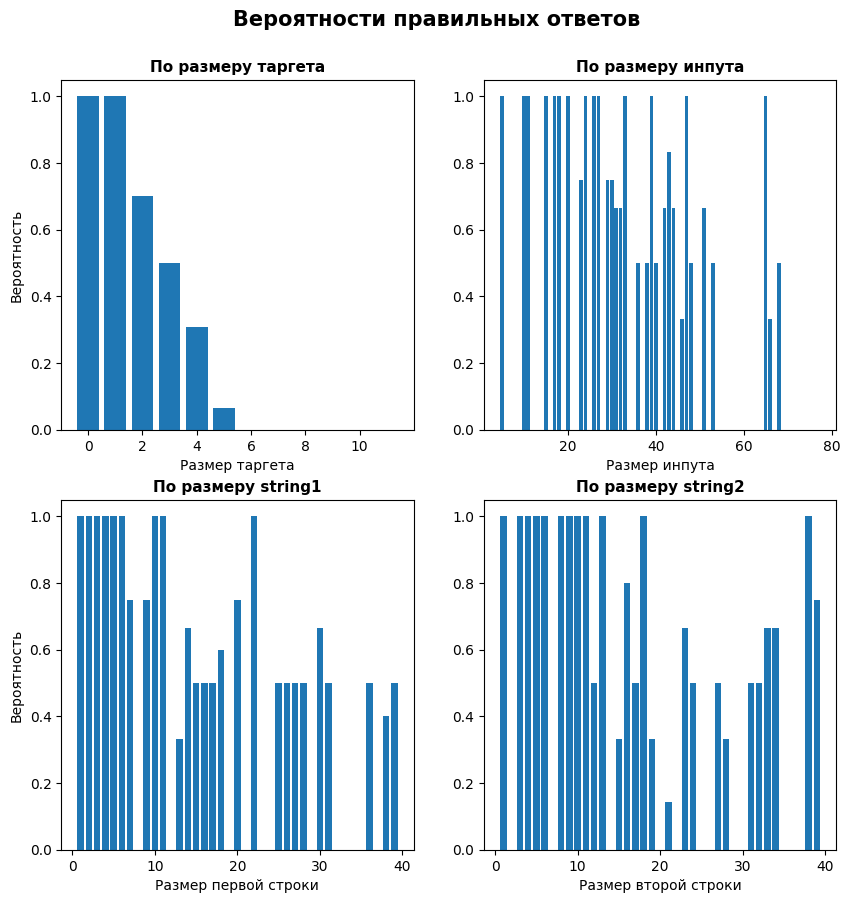

In [55]:
fig = plt.figure(figsize=(10, 10))
gs = grid(2, 2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
ax.bar(sorted(df.target.unique()), l)
ax.set_title('По размеру таргета', size=11, weight='heavy')
ax.set_xlabel('Размер таргета', size=10)
ax.set_ylabel('Вероятность', size=10)

ax = fig.add_subplot(gs[0, 1])
ax.bar(sorted(df['full_len'].unique()), l1)
ax.set_title('По размеру инпута', size=11, weight='heavy')
ax.set_xlabel('Размер инпута', size=10)

ax = fig.add_subplot(gs[1, 0])
ax.bar(sorted(df['s1_len'].unique()), l2)
ax.set_title('По размеру string1', size=11, weight='heavy')
ax.set_xlabel('Размер первой строки', size=10)
ax.set_ylabel('Вероятность', size=10)

ax = fig.add_subplot(gs[1, 1])
ax.bar(sorted(df['s2_len'].unique()), l3)
ax.set_title('По размеру string2', size=11, weight='heavy')
ax.set_xlabel('Размер второй строки', size=10)

plt.suptitle('Вероятности правильных ответов', size=15, weight='bold', x=0.5, y=.95)

plt.show()

Для размеров таргета тренд очевиден и уже указан, а вот для размера входных строк тренд хоть и прослеживается - меньше высоких столбцов, но все же содержит шумы, где даже для длинных строк ответ дается правильный, что также объяснимо хотя бы тем, что есть задания, где олна строка очень большая, а другая очень маленькая, а также задания, где две строки очень большие, но общих символов у них почти нет, что можно заметить глазами и дать правильный ответ